In [1]:
from types import SimpleNamespace
import pandas as pd
import numpy as np

In [2]:
### 학습용 데이터 로드
def loadEvaluationData():
    label = pd.read_csv("data/Participant_table_labeled.csv")
    ehr = pd.read_csv("data/EHR.csv")
    label = label[label["risk"] != -1]
    label = label[["Participant ID", "risk"]]

    lid = list(label["Participant ID"])
    eid = list(ehr["Participant ID"])

    if all(x == y for x, y in zip(lid, eid)) == True:
        label = np.array(label["risk"])
        ehr = np.array(ehr.drop(columns = ["Participant ID"]))
    else:
        raise ValueError("Participant IDs do not match across label and ehr datasets.")
    print(ehr.shape)
    print(label.shape)
    return ehr, label

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import pickle

test_size = 0.2
random_seed = 42

ehr, label = loadEvaluationData()


tab_X_train, tab_X_val, y_train, y_val = train_test_split(ehr, label, test_size=0.2, random_state=random_seed)

imputer = KNNImputer(n_neighbors=1000)
scaler = StandardScaler()
    
tab_X_train_scaled = scaler.fit_transform(tab_X_train)
tab_X_val_scaled = scaler.transform(tab_X_val)

tab_X_train_imputed = imputer.fit_transform(tab_X_train_scaled)
tab_X_val_imputed = imputer.transform(tab_X_val_scaled)

with open('src/preprocessor/scaler_XGB.pkl','wb') as sc:
    pickle.dump(scaler, sc)
with open('src/preprocessor/imputer_XGB.pkl','wb') as im:
    pickle.dump(imputer, im)


continuous_cols_list = [['Age at recruitment_x'], ['Urea | Instance 0_x'], ['Creatinine | Instance 0_x'], ['Haemoglobin concentration | Instance 0'], ['White blood cell (leukocyte) count | Instance 0_x'], ['Albumin | Instance 0_x'], ['Platelet count | Instance 0_x'], ['Platelet distribution width | Instance 0'], ['Diastolic blood pressure_x'], ['Diastolic blood pressure2_x'], ['Haematocrit percentage | Instance 0'], ['Lymphocyte percentage | Instance 0'], ['Neutrophill percentage | Instance 0'], ['Red blood cell (erythrocyte) count | Instance 0'], 
                    ['Alanine aminotransferase | Instance 0'], ['Albumin | Instance 0_y'], ['Alkaline phosphatase | Instance 0'], ['Apolipoprotein A | Instance 0'], ['Apolipoprotein B | Instance 0'], ['Aspartate aminotransferase | Instance 0'], ['C-reactive protein | Instance 0'], ['Calcium | Instance 0'], ['Cholesterol | Instance 0'], ['Cystatin C | Instance 0'], ['Direct bilirubin | Instance 0'], ['Gamma glutamyltransferase | Instance 0'], ['Glucose | Instance 0'], ['Glycated haemoglobin (HbA1c) | Instance 0'], ['HDL cholesterol | Instance 0'],
                    ['IGF-1 | Instance 0'], ['LDL direct | Instance 0'], ['Lipoprotein A | Instance 0'], ['Phosphate | Instance 0'], ['Total bilirubin | Instance 0'], ['Total protein | Instance 0'], ['Triglycerides | Instance 0'], ['Summed MET minutes per week for all activity | Instance 0'], ['Systolic blood pressure'], ['Systolic blood pressure2'], ['Pulse rate'], ['Pulse rate2'], ['CKMT1A_CKMT1B;Creatine kinase U-type'], ['NTproBNP;N-terminal prohormone of brain natriuretic peptide'], ['NBL1;Neuroblastoma suppressor of tumorigenicity 1'],
                    ['LGALS3;Galectin-3'], ['Urate | Instance 0'], ['Vitamin D | Instance 0'], ['Microalbumin in urine | Instance 0'], ['Standing height | Instance 0'], ['Weight | Instance 0'], ['Body mass index (BMI) | Instance 0']]

categorical_cols_list = [['Sex_x_encoded'], ['Ethnic background | Instance 0_encoded'], ['Sleeplessness / insomnia | Instance 0_encoded'], ['Smoking status | Instance 0_x_encoded'], ['Processed meat intake | Instance 0_encoded'], ['Coffee intake | Instance 0_encoded'], ['Alcohol drinker status | Instance 0_x_encoded'], ['Alcohol intake frequency. | Instance 0_encoded'], ['Pace-maker | Instance 0_encoded']]

continuous_cols = []
categorical_cols = []

for i in continuous_cols_list:
    continuous_cols.append(i[0])

for i in categorical_cols_list:
    categorical_cols.append(i[0])

cols = []
for col_list in continuous_cols_list + categorical_cols_list:
    cols.extend(col_list)

data = pd.DataFrame(tab_X_train_imputed, columns = cols, dtype = float)
X_test = pd.DataFrame(tab_X_val_imputed, columns = cols, dtype = float)
label = np.array(y_train)
y_test = np.array(y_val)

(8556, 60)
(8556,)


In [4]:
import importlib

def prepare_config(target_config: str) -> SimpleNamespace:
    configlib = importlib.import_module('src.config')
    config = getattr(configlib, target_config)
    
    config.model.out_dim = 2
    
    config.experiment.metric = "f1_score"
    # config.experiment.metric = "accuracy_score"
    # config.experiment.metric = "recall_score"
    config.experiment.metric_params = []
    config.experiment.data_config = "EHR"
    config.experiment.optuna.direction = 'maximize'
    config.experiment.random_seed = random_seed
    config.experiment.task = "binary"
    
    config.experiment.optuna.n_trials = 100
    
    config.experiment.calibrator = "HistogramBinning"
    
    config.experiment.KFold = 5
    config.experiment.early_stopping_patience = 30
    config.dice.backend = "sklearn"
    
    config.experiment.fast_dev_run = False
    return config

In [5]:
config = prepare_config('xgb_config')

In [6]:
from src.models import BaseModel
from src.misc.eval_metric import EvalMetric
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, recall_score, average_precision_score
from typing import Type

class EHREvalMetric(EvalMetric):
    def eval(self, model: Type[BaseModel], X_test: pd.DataFrame, y_test: np.array):
        preds_proba = model.predict_proba(X_test)
        preds = preds_proba.argmax(1)
        
        f1 = f1_score(y_test, preds)
        roc = roc_auc_score(y_test, preds_proba[:, 1])
        specificity = recall_score(np.logical_not(y_test) , np.logical_not(preds))
        sensitivity = recall_score(y_test, preds)
        accuracy = accuracy_score(y_test, preds)
        pr_auc = average_precision_score(y_test, preds_proba[:, 1])
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        ppv = tp / (tp + fp)
        npv = tn / (tn + fn)
        
        print("F1 Score: %.4f" % f1)
        print("ROC AUC Score: %.4f" % roc)
        print("Specificity Score: %.4f" % specificity)
        print("Sensitivity Score: %.4f" % sensitivity)
        print("Accuracy Score: %.4f" % accuracy)
        print("Precision Recall AUC Score: %.4f" % pr_auc)
        print("PPV Score: %.4f" % ppv)
        print("NPV Score: %.4f" % npv)

        return {
            "F1 Score" : f1,
            "ROC AUC Score" : roc,
            "Specificity Score" : specificity,
            "Sensitivity Score" : sensitivity,
            "Accuracy Score" : accuracy,
            "Precision Recall AUC Score" : pr_auc,
            "PPV Score" : ppv,
            "NPV Score" : npv
        }

In [7]:
from src.rias import RIAS
from src.models import XGB

rias = RIAS.prepare_rias(config, XGB, data, label, continuous_cols, categorical_cols, True)

rias.train()

rias.init_calibrator()
rias.test(X_test, y_test, EHREvalMetric())

/usr/local/lib/python3.8/dist-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "
2024-05-25 09:29:11.175903: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-25 09:29:12.078112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[I 2024-05-25 09:29:12,601] A new study created in memory with name: no-name-a6234938-c71b-4826-a9f0-aec9c01e8ee8
[I 2024-05-25 09:32:03,706] Trial 0 finished with value: 0.32673488462439504 and parameters: {'max_leaves': 1686, 'n_estimators': 28

Best Parameters
{'max_leaves': 1512, 'n_estimators': 1444, 'learning_rate': 0.004584213826059029, 'max_depth': 3, 'scale_pos_weight': 5}
Validation Score: 0.4251
Uncalibrated ECE : 0.33680003639814016
Calibrated ECE : 2.8559960175563225e-16
Uncalibrated ECE : 0.33680003639814016
Calibrated ECE : 2.8559960175563225e-16
F1 Score: 0.4026
ROC AUC Score: 0.5902
Specificity Score: 0.2887
Sensitivity Score: 0.8160
Accuracy Score: 0.4159
Precision Recall AUC Score: 0.2930
PPV Score: 0.2672
NPV Score: 0.8315


{'F1 Score': 0.40262843488649935,
 'ROC AUC Score': 0.5902323821453269,
 'Specificity Score': 0.28868360277136257,
 'Sensitivity Score': 0.8159806295399515,
 'Accuracy Score': 0.4158878504672897,
 'Precision Recall AUC Score': 0.29302053713641746,
 'PPV Score': 0.26724821570182394,
 'NPV Score': 0.8314855875831486}

In [8]:
dice_d = X_test.iloc[:10].copy()

print(dice_d)
print(type(dice_d))

   Age at recruitment_x  Urea | Instance 0_x  Creatinine | Instance 0_x  \
0             -1.872432            -0.483296                  -0.577454   
1              0.603786            -0.155854                  -0.050247   
2             -1.212107             5.616649                  12.810969   
3              0.768868             0.201745                   0.293439   
4              0.933949             0.174805                  -0.075336   
5              0.603786            -0.140775                  -0.500365   
6              0.933949             7.117582                   5.122939   
7              0.603786            -0.059956                   0.283022   
8             -0.221620            -0.167488                   0.002636   
9             -0.056539            -0.283171                   0.216351   

   Haemoglobin concentration | Instance 0  \
0                               -0.091121   
1                                0.028736   
2                               -0.0206

In [9]:
dice = rias.get_counterfactual_explanations(dice_d, features_to_vary=["Cholesterol | Instance 0", "Weight | Instance 0"])

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:33<00:00,  9.35s/it]

Query instance (original outcome : 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,-1.872432,-0.483296,-0.577454,-0.091121,-0.672635,-0.568439,-1.05287,1.268577,0.582594,0.791701,...,1.4686138254373244,-0.269760297135527,0.32683821434180793,0.1048560631458576,-0.24456856308405314,1.358702896433432,2.977353463491117,1.4174745449852848,-0.17696396228338865,0



Diverse Counterfactual set (new outcome: 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,-1.872432,-0.483296,-0.577454,-0.091121,-0.672635,-0.568439,-1.05287,1.268577,0.582594,0.791701,...,1.468614,-0.26976,0.326838,0.104856,-0.244569,1.358703,2.977353,1.417475,-0.176964,0
1,-1.872432,-0.483296,-0.577454,-0.091121,-0.672635,-0.568439,-1.05287,1.268577,0.582594,0.791701,...,1.468614,-0.26976,0.326838,0.104856,-0.244569,1.358703,2.977353,1.417475,-0.176964,0
2,-1.872432,-0.483296,-0.577454,-0.091121,-0.672635,-0.568439,-1.05287,1.268577,0.582594,0.791701,...,1.468614,-0.26976,0.326838,0.104856,-0.244569,1.358703,2.977353,1.417475,-0.176964,0
3,-1.872432,-0.483296,-0.577454,-0.091121,-0.672635,-0.568439,-1.05287,1.268577,0.582594,0.791701,...,1.468614,-0.26976,0.326838,0.104856,-0.244569,1.358703,2.977353,1.417475,-0.176964,0


Query instance (original outcome : 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,0.603786,-0.155854,-0.050247,0.028736,1.38285,0.050007,1.288365,0.566916,0.251619,0.706121,...,-0.68091419451414,-0.269760297135527,1.6387917269255816,-0.9791845655101079,-1.021286542549139,3.573268893859107,-0.38297092703216873,0.2789701692219603,-0.17696396228338865,0



Diverse Counterfactual set (new outcome: 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,0.603786,-0.155854,-0.050247,0.028736,1.38285,0.050007,1.288365,0.566916,0.251619,0.706121,...,-0.680914,-0.26976,1.638792,-0.979185,-1.021287,3.573269,-0.382971,0.27897,-0.176964,0
1,0.603786,-0.155854,-0.050247,0.028736,1.38285,0.050007,1.288365,0.566916,0.251619,0.706121,...,-0.680914,-0.26976,1.638792,-0.979185,-1.021287,3.573269,-0.382971,0.27897,-0.176964,0
2,0.603786,-0.155854,-0.050247,0.028736,1.38285,0.050007,1.288365,0.566916,0.251619,0.706121,...,-0.680914,-0.26976,1.638792,-0.979185,-1.021287,3.573269,-0.382971,0.27897,-0.176964,0
3,0.603786,-0.155854,-0.050247,0.028736,1.38285,0.050007,1.288365,0.566916,0.251619,0.706121,...,-0.680914,-0.26976,1.638792,-0.979185,-1.021287,3.573269,-0.382971,0.27897,-0.176964,0


Query instance (original outcome : 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,-1.212107,5.616649,12.810969,-0.020617,3.003232,-0.022314,0.228773,-0.170727,-1.237764,-0.577578,...,1.4686138254373244,-0.269760297135527,0.32683821434180793,1.1888966918018231,0.5321494163810329,0.6205142306248738,1.297191268229474,1.4174745449852848,-0.17696396228338865,0



Diverse Counterfactual set (new outcome: 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,-1.212107,5.616649,12.810969,-0.020617,3.003232,-0.022314,0.228773,-0.170727,-1.237764,-0.577578,...,1.468614,-0.26976,0.326838,1.188897,0.532149,0.620514,1.297191,1.417475,-0.176964,0
1,-1.212107,5.616649,12.810969,-0.020617,3.003232,-0.022314,0.228773,-0.170727,-1.237764,-0.577578,...,1.468614,-0.26976,0.326838,1.188897,0.532149,0.620514,1.297191,1.417475,-0.176964,0
2,-1.212107,5.616649,12.810969,-0.020617,3.003232,-0.022314,0.228773,-0.170727,-1.237764,-0.577578,...,1.468614,-0.26976,0.326838,1.188897,0.532149,0.620514,1.297191,1.417475,-0.176964,0
3,-1.212107,5.616649,12.810969,-0.020617,3.003232,-0.022314,0.228773,-0.170727,-1.237764,-0.577578,...,1.468614,-0.26976,0.326838,1.188897,0.532149,0.620514,1.297191,1.417475,-0.176964,0


Query instance (original outcome : 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,0.768868,0.201745,0.293439,0.656222,1.08653,-0.844755,-0.47464,-0.134744,0.097965,0.089603,...,-0.68091419451414,-0.269760297135527,-0.9851152982419655,-0.9791845655101079,0.5321494163810329,-1.224957433896522,-0.38297092703216873,0.2789701692219603,-0.17696396228338865,0



Diverse Counterfactual set (new outcome: 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,0.768868,0.201745,0.293439,0.656222,1.08653,-0.844755,-0.47464,-0.134744,0.097965,0.089603,...,-0.680914,-0.26976,-0.985115,-0.979185,0.532149,-1.224957,-0.382971,0.27897,-0.176964,0
1,0.768868,0.201745,0.293439,0.656222,1.08653,-0.844755,-0.47464,-0.134744,0.097965,0.089603,...,-0.680914,-0.26976,-0.985115,-0.979185,0.532149,-1.224957,-0.382971,0.27897,-0.176964,0
2,0.768868,0.201745,0.293439,0.656222,1.08653,-0.844755,-0.47464,-0.134744,0.097965,0.089603,...,-0.680914,-0.26976,-0.985115,-0.979185,0.532149,-1.224957,-0.382971,0.27897,-0.176964,0
3,0.768868,0.201745,0.293439,0.656222,1.08653,-0.844755,-0.47464,-0.134744,0.097965,0.089603,...,-0.680914,-0.26976,-0.985115,-0.979185,0.532149,-1.224957,-0.382971,0.27897,-0.176964,0


Query instance (original outcome : 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,0.933949,0.174805,-0.075336,-0.344936,-0.413824,0.122451,-1.057341,1.71836,-0.90679,-0.834318,...,-0.68091419451414,-0.269760297135527,-0.9851152982419655,1.1888966918018231,-1.021286542549139,-1.224957433896522,-0.38297092703216873,0.8482223571036226,-0.17696396228338865,0



Diverse Counterfactual set (new outcome: 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,0.933949,0.174805,-0.075336,-0.344936,-0.413824,0.122451,-1.057341,1.71836,-0.90679,-0.834318,...,-0.680914,-0.26976,-0.985115,1.188897,-1.021287,-1.224957,-0.382971,0.848222,-0.176964,0
1,0.933949,0.174805,-0.075336,-0.344936,-0.413824,0.122451,-1.057341,1.71836,-0.90679,-0.834318,...,-0.680914,-0.26976,-0.985115,1.188897,-1.021287,-1.224957,-0.382971,0.848222,-0.176964,0
2,0.933949,0.174805,-0.075336,-0.344936,-0.413824,0.122451,-1.057341,1.71836,-0.90679,-0.834318,...,-0.680914,-0.26976,-0.985115,1.188897,-1.021287,-1.224957,-0.382971,0.848222,-0.176964,0
3,0.933949,0.174805,-0.075336,-0.344936,-0.413824,0.122451,-1.057341,1.71836,-0.90679,-0.834318,...,-0.680914,-0.26976,-0.985115,1.188897,-1.021287,-1.224957,-0.382971,0.848222,-0.176964,0


Query instance (original outcome : 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,0.603786,-0.140775,-0.500365,0.642121,1.686672,0.096644,0.303288,-1.070292,0.334363,-0.064098,...,1.4686138254373244,-0.269760297135527,-0.9851152982419655,0.1048560631458576,-1.021286542549139,-1.224957433896522,-0.38297092703216873,0.2789701692219603,-0.17696396228338865,0



Diverse Counterfactual set (new outcome: 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,0.603786,-0.140775,-0.500365,0.642121,1.686672,0.096644,0.303287,-1.070292,0.334363,-0.064098,...,1.468614,-0.26976,-0.985115,0.104856,-1.021287,-1.224957,-0.382971,0.27897,-0.176964,0
1,0.603786,-0.140775,-0.500365,0.642121,1.686672,0.096644,0.303287,-1.070292,0.334363,-0.064098,...,1.468614,-0.26976,-0.985115,0.104856,-1.021287,-1.224957,-0.382971,0.27897,-0.176964,0
2,0.603786,-0.140775,-0.500365,0.642121,1.686672,0.096644,0.303287,-1.070292,0.334363,-0.064098,...,1.468614,-0.26976,-0.985115,0.104856,-1.021287,-1.224957,-0.382971,0.27897,-0.176964,0
3,0.603786,-0.140775,-0.500365,0.642121,1.686672,0.096644,0.303287,-1.070292,0.334363,-0.064098,...,1.468614,-0.26976,-0.985115,0.104856,-1.021287,-1.224957,-0.382971,0.27897,-0.176964,0


Query instance (original outcome : 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,0.933949,7.117582,5.122939,-0.993573,1.210309,-0.024442,0.280933,-1.358153,-2.396174,-2.545918,...,-0.68091419451414,-0.269760297135527,-0.9851152982419655,0.1048560631458576,-1.021286542549139,-0.48676876808796365,-0.38297092703216873,0.8482223571036226,-0.17696396228338865,0



Diverse Counterfactual set (new outcome: 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,0.933949,7.117582,5.122939,-0.993573,1.210309,-0.024442,0.280933,-1.358153,-2.396174,-2.545918,...,-0.680914,-0.26976,-0.985115,0.104856,-1.021287,-0.486769,-0.382971,0.848222,-0.176964,0
1,0.933949,7.117582,5.122939,-0.993573,1.210309,-0.024442,0.280933,-1.358153,-2.396174,-2.545918,...,-0.680914,-0.26976,-0.985115,0.104856,-1.021287,-0.486769,-0.382971,0.848222,-0.176964,0
2,0.933949,7.117582,5.122939,-0.993573,1.210309,-0.024442,0.280933,-1.358153,-2.396174,-2.545918,...,-0.680914,-0.26976,-0.985115,0.104856,-1.021287,-0.486769,-0.382971,0.848222,-0.176964,0
3,0.933949,7.117582,5.122939,-0.993573,1.210309,-0.024442,0.280933,-1.358153,-2.396174,-2.545918,...,-0.680914,-0.26976,-0.985115,0.104856,-1.021287,-0.486769,-0.382971,0.848222,-0.176964,0


Query instance (original outcome : 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,0.603786,-0.059956,0.283022,0.902986,0.531399,0.107321,-1.020084,0.566916,1.327286,1.989821,...,-0.68091419451414,-0.269760297135527,0.32683821434180793,-0.9791845655101079,0.5321494163810329,-1.224957433896522,-0.38297092703216873,-1.4287863944230266,-0.17696396228338865,0



Diverse Counterfactual set (new outcome: 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,0.603786,-0.059956,0.283022,0.902986,0.531399,0.107321,-1.020084,0.566916,1.327286,1.989821,...,-0.680914,-0.26976,0.326838,-0.979185,0.532149,-1.224957,-0.382971,-1.428786,-0.176964,0
1,0.603786,-0.059956,0.283022,0.902986,0.531399,0.107321,-1.020084,0.566916,1.327286,1.989821,...,-0.680914,-0.26976,0.326838,-0.979185,0.532149,-1.224957,-0.382971,-1.428786,-0.176964,0
2,0.603786,-0.059956,0.283022,0.902986,0.531399,0.107321,-1.020084,0.566916,1.327286,1.989821,...,-0.680914,-0.26976,0.326838,-0.979185,0.532149,-1.224957,-0.382971,-1.428786,-0.176964,0
3,0.603786,-0.059956,0.283022,0.902986,0.531399,0.107321,-1.020084,0.566916,1.327286,1.989821,...,-0.680914,-0.26976,0.326838,-0.979185,0.532149,-1.224957,-0.382971,-1.428786,-0.176964,0


Query instance (original outcome : 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,-0.22162,-0.167488,0.002636,0.41378,-0.066976,0.051291,-0.014924,-0.033741,1.575516,1.390761,...,-0.68091419451414,-0.269760297135527,1.6387917269255816,-0.9791845655101079,-0.24456856308405314,-0.48676876808796365,-0.38297092703216873,-1.4287863944230266,-0.17696396228338865,0



Diverse Counterfactual set (new outcome: 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,-0.22162,-0.167488,0.002636,0.41378,-0.066976,0.051291,-0.014924,-0.033741,1.575516,1.390761,...,-0.680914,-0.26976,1.638792,-0.979185,-0.244569,-0.486769,-0.382971,-1.428786,-0.176964,0
1,-0.22162,-0.167488,0.002636,0.41378,-0.066976,0.051291,-0.014924,-0.033741,1.575516,1.390761,...,-0.680914,-0.26976,1.638792,-0.979185,-0.244569,-0.486769,-0.382971,-1.428786,-0.176964,0
2,-0.22162,-0.167488,0.002636,0.41378,-0.066976,0.051291,-0.014924,-0.033741,1.575516,1.390761,...,-0.680914,-0.26976,1.638792,-0.979185,-0.244569,-0.486769,-0.382971,-1.428786,-0.176964,0
3,-0.22162,-0.167488,0.002636,0.41378,-0.066976,0.051291,-0.014924,-0.033741,1.575516,1.390761,...,-0.680914,-0.26976,1.638792,-0.979185,-0.244569,-0.486769,-0.382971,-1.428786,-0.176964,0


Query instance (original outcome : 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,-0.056539,-0.283171,0.216351,2.291916,-0.702642,0.124985,-0.31369,2.635916,1.65826,1.989821,...,-0.68091419451414,-0.269760297135527,1.6387917269255816,-0.9791845655101079,-1.021286542549139,-1.224957433896522,-0.38297092703216873,-1.4287863944230266,-0.17696396228338865,0



Diverse Counterfactual set (new outcome: 0)


,Age at recruitment_x,Urea | Instance 0_x,Creatinine | Instance 0_x,Haemoglobin concentration | Instance 0,White blood cell (leukocyte) count | Instance 0_x,Albumin | Instance 0_x,Platelet count | Instance 0_x,Platelet distribution width | Instance 0,Diastolic blood pressure_x,Diastolic blood pressure2_x,...,Sex_x_encoded,Ethnic background | Instance 0_encoded,Sleeplessness / insomnia | Instance 0_encoded,Smoking status | Instance 0_x_encoded,Processed meat intake | Instance 0_encoded,Coffee intake | Instance 0_encoded,Alcohol drinker status | Instance 0_x_encoded,Alcohol intake frequency. | Instance 0_encoded,Pace-maker | Instance 0_encoded,target
0,-0.056539,-0.283171,0.216351,2.291916,-0.702642,0.124985,-0.31369,2.635916,1.65826,1.989821,...,-0.680914,-0.26976,1.638792,-0.979185,-1.021287,-1.224957,-0.382971,-1.428786,-0.176964,0
1,-0.056539,-0.283171,0.216351,2.291916,-0.702642,0.124985,-0.31369,2.635916,1.65826,1.989821,...,-0.680914,-0.26976,1.638792,-0.979185,-1.021287,-1.224957,-0.382971,-1.428786,-0.176964,0
2,-0.056539,-0.283171,0.216351,2.291916,-0.702642,0.124985,-0.31369,2.635916,1.65826,1.989821,...,-0.680914,-0.26976,1.638792,-0.979185,-1.021287,-1.224957,-0.382971,-1.428786,-0.176964,0
3,-0.056539,-0.283171,0.216351,2.291916,-0.702642,0.124985,-0.31369,2.635916,1.65826,1.989821,...,-0.680914,-0.26976,1.638792,-0.979185,-1.021287,-1.224957,-0.382971,-1.428786,-0.176964,0


In [10]:
dice.cf_examples_list[0].final_cfs_df.to_csv(path_or_buf='src/dice/counterfactuals_XGB.csv', index=False)

In [11]:
rias.init_shap_explainer()
rias.calculate_shap_values()

Permutation explainer: 6845it [14:49,  7.63it/s]                                                                                     


In [12]:
import shap
shap.initjs()

In [13]:
rias.save_rias()

loaded_name model
loaded_name model
loaded_name masker
loaded_name data
loaded_name max_samples
loaded_name clustering
loaded_name link


In [21]:
new_rias = RIAS.load_rias("rias_checkpoints/EHR-XGB-2024_05_25-09_29_10.pickle")

loaded_name model
loaded_name model
loaded_name masker
loaded_name data
loaded_name max_samples
loaded_name clustering
loaded_name link


In [22]:
shap.initjs()
new_rias.report_pred(X_test.iloc[0], 1, True)

Permutation explainer: 1713it [25:35,  1.11it/s]                                                                                     


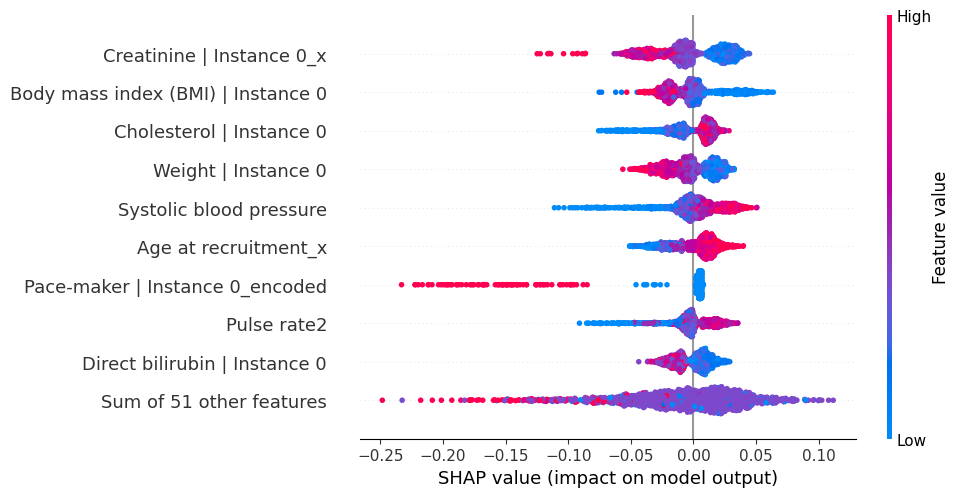

In [25]:
import shap
shap_values = rias.shap_explainer(X_test)
shap.plots.beeswarm(shap_values[:, :, 1])

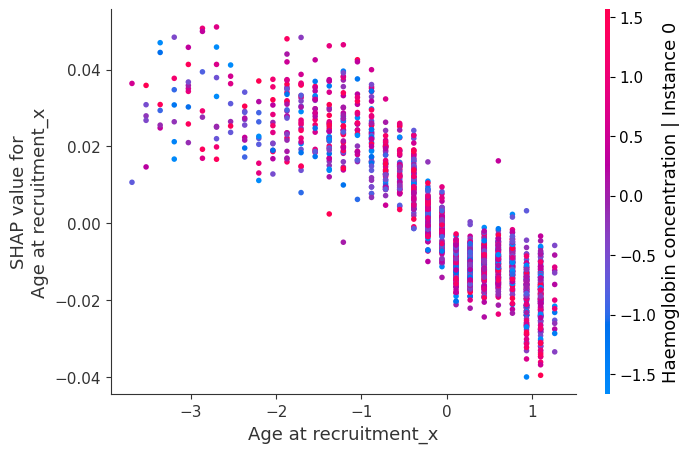

In [26]:
shap.dependence_plot("Age at recruitment_x", shap_values.values[:, :, 0], X_test, interaction_index=3)

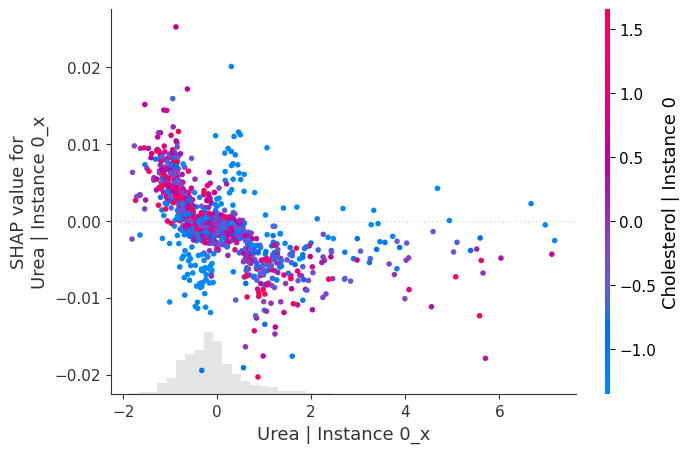

In [27]:
shap.plots.scatter(shap_values[:, "Urea | Instance 0_x", 1], color=shap_values[:,:,1])